# Predicting Destinations with the Airbnb Dataset

![](https://www.wearedesignstudio.com/wp-content/uploads/2014/07/Brand_Case_Study3.gif)

This notebook demonstrates the entire process of building a predictive model to suggest the first destination of new Airbnb Users. All the processes involved, such as data wrangling, exploratory data analysis, inferential statistics and machine learning have been divided into main sections and the reader is strongly advised to read it sequentially, from top to bottom.


## Data Wrangling
In the first section of the notebook, I will attempt at cleaning the Airbnb Kaggle Competition Data and wrangling into a form that is suitable for further analysis. The entire data wrangling process will be done using the Python Pandas library.

![](https://media.tenor.com/images/566ce1e7cba9fe90d18e9b1f395e20e8/tenor.gif)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

The first step is to load all the data available to us in a Pandas Dataframe and extract basic information such as number of samples, number of null values rows, number of features, etc. The next step would be to deal with the missing values using a suitable method (dropping, interpolating, etc.) and convert certain features into a more suitable form for applying inferential statistics and machine learning algorithms.

### Age, Gender and Population Statistics

![](http://www.queercafe.net/div24.gif)

In [2]:
df_agb = pd.read_csv('../input/age_gender_bkts.csv')
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [3]:
df_agb.isnull().values.any()

False

This dataset has no null values amongst its features.

As a first step, let us deal with the age bucket. The ages are given in bins of size 5. We will convert this to a numerical value so that we can increase its versaility should the need arise (that is, it can be used both as a categorical and a continuous feature). As the bin size is reasonably small, we can define a new feature, mean_age which can represent ages without too much loss of information. The mean_age will be the average of the upper and lower range for that particular bin.

In [4]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [5]:
df_agb['country_destination'].value_counts()

GB    42
US    42
ES    42
DE    42
IT    42
PT    42
NL    42
AU    42
FR    42
CA    42
Name: country_destination, dtype: int64

The number of countries is extremely small. It probably corresponds to the country classes available in the training dataset which we will cover later in this section.

In [6]:
df_agb['gender'].value_counts()

female    210
male      210
Name: gender, dtype: int64

The gender can also be turned into a categorical binary variable. Let us represent **male with 0 and female with 1.** Again, we do this just in case we require this variable to function as a numerical quantity. It must be stated that there is no immediate need for it and therefore, can be skipped.

In [7]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

1    210
0    210
Name: gender, dtype: int64

In [8]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

There is only value available for the year feature. Therefore, it makes no sense to keep this feature as it doesn't add any information about the data available to us. We shall drop this feature.

In [9]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


### Country Statistics

![](http://eurosport-tour.com/images/world-map.gif)

In [10]:
df_con = pd.read_csv('../input/countries.csv')
df_con

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


As such, we do not need to do any cleaning for this (extremely small) dataset. The statistics given here will have to be incorporated into our training and testing datasets before training our model and/or will have to be used in exploratory data analysis to come up with additional insights. 

### Sessions 

![](http://31.media.tumblr.com/1bc35aca0aadec9ad3bce5f390a8b1fc/tumblr_nshjo51JSn1qf2fu4o1_500.gif)

In [11]:
df_ses = pd.read_csv('../input/sessions.csv')
df_ses.head(15)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,255.0
1,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,183.0
2,ailzdefy6o,ajax_refresh_subtotal,click,change_trip_characteristics,Windows Desktop,175570.0
3,ailzdefy6o,show,NaN,NaN,Windows Desktop,86.0
4,ailzdefy6o,personalize,data,wishlist_content_update,Windows Desktop,1535.0
5,ailzdefy6o,show,view,p3,Windows Desktop,83251.0
6,ailzdefy6o,lookup,NaN,NaN,Windows Desktop,360.0
7,ailzdefy6o,search_results,click,view_search_results,Windows Desktop,2488.0
8,ailzdefy6o,lookup,NaN,NaN,Windows Desktop,456.0
9,ailzdefy6o,search_results,click,view_search_results,Windows Desktop,10053.0


In [12]:
df_ses.shape

(5600850, 6)

We will replace the unknown values with NaN to give it some semantic meaning. We can always revert back to unknown should the need arise or should our EDA suggest that labelling unavailable data as unknown values will lead to better predictions.

In [13]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

First, let us have a look at the secs_elapsed variable.

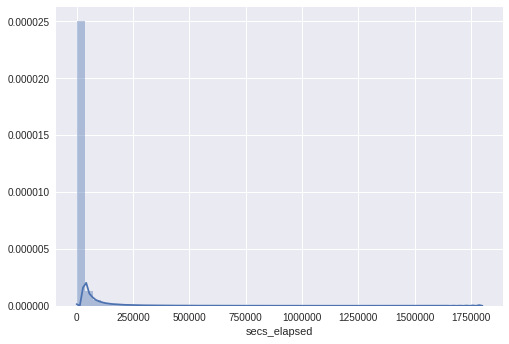

In [14]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [15]:
df_ses['secs_elapsed'].describe()

count    5.526240e+06
mean     2.042468e+04
std      9.252944e+04
min      0.000000e+00
25%      2.360000e+02
50%      1.139000e+03
75%      8.486000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

The average number of seconds per session is **19450 seconds** whereas the median value is **1147 seconds**. This suggests a heavily skewed dataset with some outlier observations influencing the mean of the distribution.

In [16]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

74610

There are more than 136,000 fields for which we do not know the value. We need to either drop or interpolate these values. For the time being, let us fill the unavailable values with the median of the distribution. We use median since, as was mentioned earlier, this distribution is heavily influenced by outliers.

In [17]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [18]:
df_ses['secs_elapsed'].describe()

count    5.600850e+06
mean     2.016777e+04
std      9.193766e+04
min      0.000000e+00
25%      2.450000e+02
50%      1.139000e+03
75%      8.217000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

As can be seen above, the interpolation has not significantly altered the summary statistics of the distribution. This is a good option for filling in the null values for the time being.

In [19]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3,ailzdefy6o,show,NaN,NaN,Windows Desktop,86.0
6,ailzdefy6o,lookup,NaN,NaN,Windows Desktop,360.0
8,ailzdefy6o,lookup,NaN,NaN,Windows Desktop,456.0
11,ailzdefy6o,lookup,NaN,NaN,Windows Desktop,1996.0
13,ailzdefy6o,show,NaN,NaN,Windows Desktop,102.0


In [20]:
null_action.shape

(1248270, 6)

In [21]:
len(null_action['action'].drop_duplicates())

246

There are over 2.23 million fields that have incomplete information about the action, action type or action detail. This is approximately 20% of the data that we possess. Additionally, there are 270 types of action for which we have null values, so examining them one by one is simply not feasible manually.

Since this is not our training dataset, we will not drop the values. We shall keep because it is possible to extract information even from rows which have null columns.

In [22]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [23]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [24]:
df_ses['device_type'].value_counts()

Mac Desktop                         2177277
Windows Desktop                     1567583
iPhone                               801437
iPad Tablet                          386959
Android App Unknown Phone/Tablet     268874
Android Phone                        211577
Tablet                                52560
Linux Desktop                         16720
Chromebook                            13304
iPodtouch                              4119
Blackberry                              244
Windows Phone                           216
Opera Phone                               5
Name: device_type, dtype: int64

As can be seen above, there are 13 types of devices that people are using. There is also certain activity for which we do not have data about the device. Let us check how many instances does that account for.

In [25]:
len(df_ses[df_ses['device_type'].isnull()])

99975

As with the action variables, we will not drop these values since this is not the dataset we will be applying our machine learning algorithms to. However, we will replace the unknown strings with NaN to give it more semantic meaning which might be useful in our analysis.

### Training Users

![](https://media.tenor.com/images/4ee465335c6a528c72fc30b89a4ed8d6/tenor.gif)

Let us now explore the training dataset which consists of our users for whom we need to predict the first destination. 

In [26]:
df_train = pd.read_csv('../input/train_users_2.csv')
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [27]:
df_train.shape

(213451, 16)

In [28]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [29]:
df_train[df_train['first_device_type'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination


The following features in the dataset have no null values:

1. date_account_created
2. timestamp_first_active
3. signup_method
4. signup_flow
5. language
6. affiliate_channel
7. affiliate_provider
8. signup_app
9. first_device_type

The following features in the dataset have null values:

1. date_first_booking
2. gender
3. age
4. first_affiliate_tracked
5. first_browser

In [30]:
df_train[df_train['age'] > 120].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


We notice that there are samples for which the age is much greater than 120 (the oldest person is currently 114 years old). This is clearly polluted data and must be removed. Let us replace these values with NaN to denote that we do not know the real age of these people.

In [31]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

## Inferential Statistics

### Gender Preference for Airbnb Bookings

![](https://cdn.dribbble.com/users/720472/screenshots/2020099/switch3.gif)

In this section, we will be applying statistical tools to gain some inferences and insights into the kind of data we are dealing with and disovering relationships between various features of our dataset. 

To begin, let us check if there is a gender based preference for certain countries. In other words, does the gender of a person affect the first country s/he books an Airbnb in? To answer this question we will have to test the relationship between two categorical variables: Gender and Destination Country. Since the number of destination countries is multivariate, the **Chi Square Square Significance Test**.

Before we begin, we will make certain assumptions:
* We will consider only those users who have enlisted their gender as male or female. Unknown and other genders are not included in this analysis.
* We do not consider users who have never booked an Airbnb or have booked in a country not enlisted as a class (NDF and Other).

In [32]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [33]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [34]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

#### Hypothesis Testing

For the hypothesis testing, we define the following:

* **Null Hypothesis:** There is no relationship between country preference and the sex of the customer.
* **Alternate Hypothesis:** There is a relationship between country preference and the sex of the customer.

We will assume our significance level, $\alpha$ to be 0.05.

In [35]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [36]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [37]:
chi2

116.87183139602567

In [38]:
p

5.8301269550715721e-21

The p-value that we have obtained is less than our chosen significance level. Therefore, we reject the null hypothesis and accept the negating alterate hypothesis. **There is a relationship between country preference and the sex of the customer.** This information can prove extremely useful to us when performing feature engineering in later steps.


### Signup Preferences

![](https://cdn.dribbble.com/users/391028/screenshots/1241633/devices_small.gif)

In this section, we will try to discover a relationship between the signup method and the signup device. A preliminary querying of our dataframe tells us that most users signup either through the standard basic method or through Facebook. Additionally, they login using either a desktop browser, a mobile browser or a mobile app.

Does the type of device (mobile or computer) affect the signup method to Airbnb? We will try to answer this question here. Again, as aboe, we will make certain assumptions.
* We will ignore the Google Signup Method as there are extremely few instances of it.
* We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [39]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [40]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [41]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

#### Hypothesis Testing

Let us now setup our hypothesis test. We will define the following:

* **Null Hypothesis:** There is no relationship between device type and signup method.
* **Alternate Hypothesis:** There is a relationship between device type and signup method.

Assume the significance level $\alpha$ to be at 0.05.

We will be performing the same hypothesis test using two different statistical tools: The Chi Square Significance Test and the Z-Statistic Test. If performed correctly, both tests should give us the same results.

In [42]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


#### Chi Square Test

In [43]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [44]:
chi2

0.071838242734217073

In [45]:
p

0.78867886610237792

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. **There is no relationship between device type and signup method.** Let us perform the same hypothesis test using the Z-Test and compare the results and the p-value obtained.

#### Two Sample Significance Test

Let us now do the same hypothesis testing using the two sample significance test for proportions.

In [46]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [47]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.34916741886407238)

In [48]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [49]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook']) 
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.00045038872523339712, 0.001680388342245922)

In [50]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.26802657094813592

In [51]:
p = (1-stats.norm.cdf(z))*2
p

0.78867886610237936

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. **There is no relationship between device type and signup method.**

Also notice that the p-values obtained for Two Sample Significance Test and Chi Square Significance Test (without Correction) is **exactly the same.** We are now in a position to summarise and present our results based on the statistical analysis performed.

### Conclusions

* There is **a relationship** between gender and Airbnb Country Destination. In other words, the gender influences your country of choice.
* There is **no relationship** between device type and signup method. The two variables are independent of each other.
* The results obtained from Chi Square Significance Test and Two Sample Significance Test are **exactly the same**.

## Exploratory Data Analysis

![](http://lightning-viz.org/images/streaming/line-streaming.gif)

In this section, we will try to visualise and summairise our data to extract new insights about individual features and the relationship they share with the other features. Let us first try and visualise the age and gender statistics of various countries. 



### Country Statistics

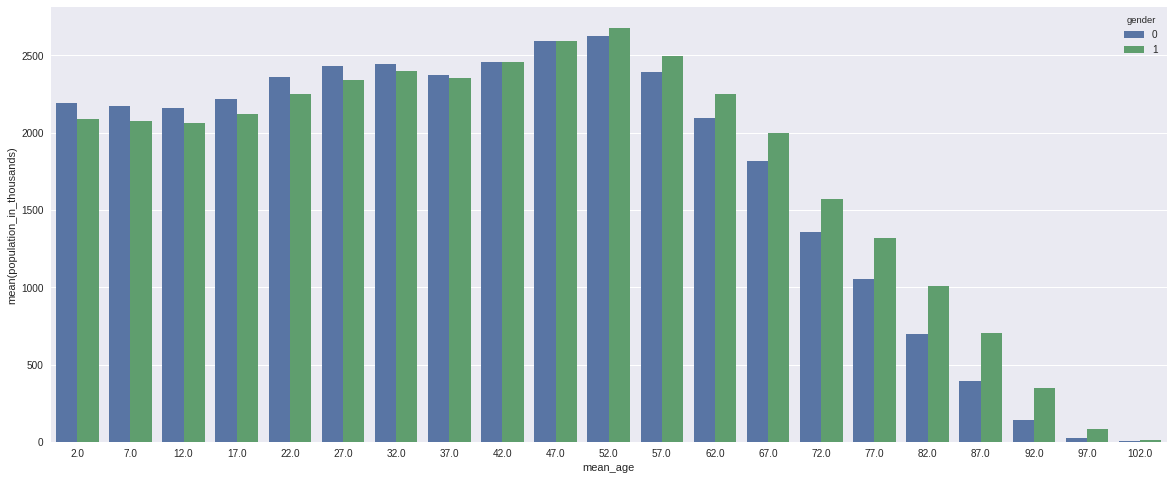

In [52]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)

#### Observations

* The countries that are represented in this statistic largely consist of an **aging population**. The largest groups are people with **mean ages 47 years and 52 years**.
* The distribution resembles a skewed bell curve. The middle aged people occupy the largest share of the population, closely followed by the youth and finally, the old.
* The population counts of young and middle aged people are fairly comparable. But as we transition towards old age (age > 57 years), the population count for every successive bucket decreases steadily.
* One very interesting thing to note (although it may not be relevant to our analysis) is that the sex ratio is skewed towards men for younger age groups but as the mean age increases, the ratio skews more towards women. **Women indeed live longer than men.**

Next, let us try and graph the population count in each country.

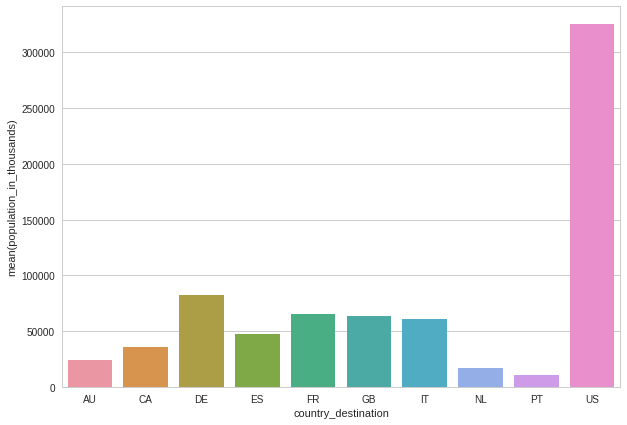

In [53]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

**The United States of America** is clearly the most populated nation amongst the destination countries with a population of over **300 million**. All the other countries in the list have a **population less than 100 million.**

Next, let us create a bar plot of the distance of the country from the country of origin (United States of America). We will then construct a scatterplot between the frequency of booking in a country and the distance of the country. My initial hunch is that the further a country, the less likely people are to visit that particular country. There must be at least a small megative correlation between these two quantities.

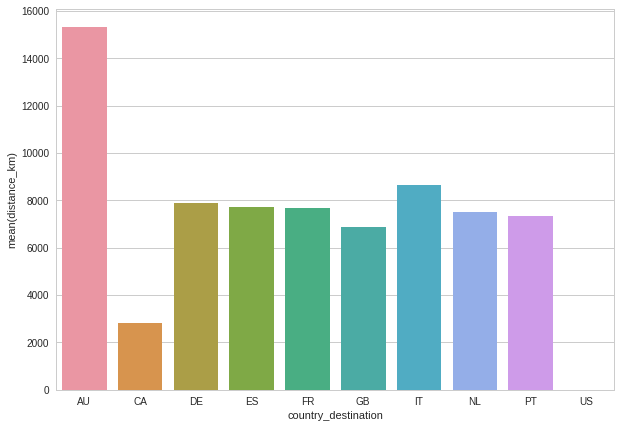

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

In [55]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [56]:
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [57]:
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [58]:
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

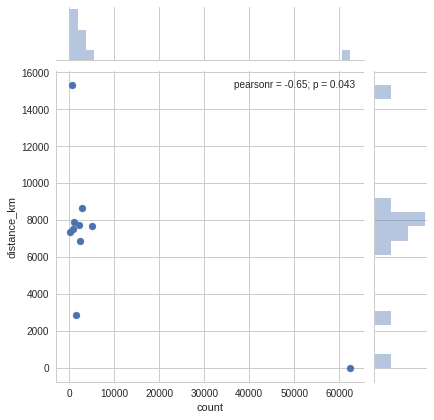

In [59]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

There is a **strong negative correlation of -0.65.** People overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

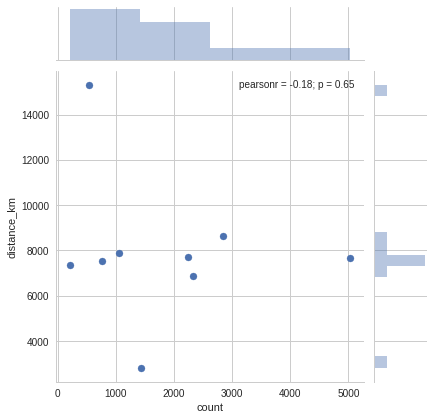

In [60]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

The correlation, with United States out of the equation, **is much lower at -0.18.** However, there is still a negative correlation between the two quantities.

Next, let us check if the language spoken in a particular country influences the number of bookings in that country. To calculate this metric, we will use the **Language Levenshtein Distance** of each country's official language from English. This data is already made available to us by Airbnb. Again, like physical distance, my guess is that lower the levenshtein distance, greater the number of bookings in that country.

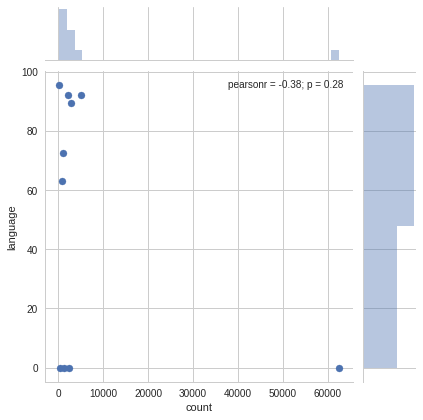

In [61]:
sns.jointplot(x='count', y='language', data=df_dp)

There seems to be a **medium negative correlation of -0.38** between the two quantities. This suggests that people indeed prefer countries that speak English. But is that really the case? Let us remove United States, the home country, once again and recalculate our correlation coefficient.

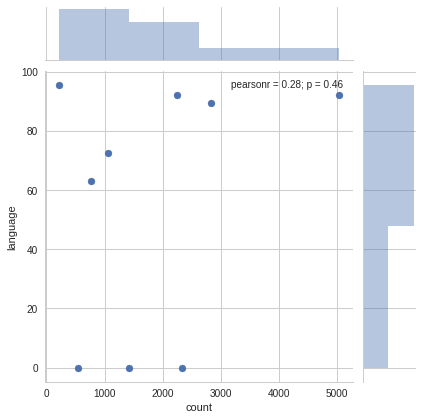

In [62]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

The result of this visualisation is extremely interesting. 

* We see that when United States is removed from the list of countries, there is actually **a positive correlation** between language distance and booking frequency. 
* At first glance, this may suggest that people prefer countries with different language (and therefore culture) while travelling abroad. 
* Another way of looking at it would be that **Europe is an extremely popular travel destination for Americans** and they tend to prefer it to other English Speaking countries like Canada and Australia. So this may have nothing to do with language difference as it may have to do with destination preference.

Finally, in this section, let us check if the size of the country has anything to do with booking preference. Like the previous two cases, we have data on the size of each country.

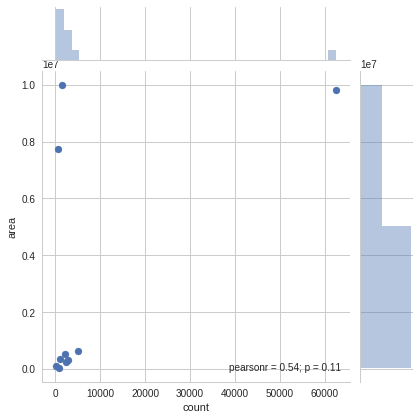

In [63]:
sns.jointplot(x='count', y='area', data=df_dp)

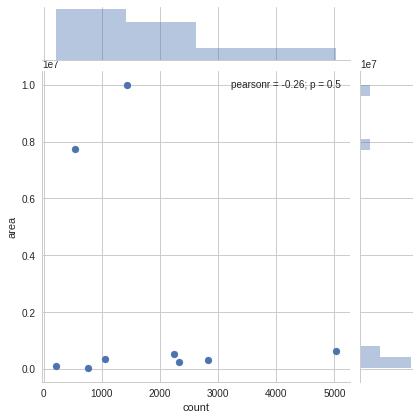

In [64]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

The results with area closely resemble what we've gained from our tests on language distance. Overall, there is a positive correlation between the size of the country and the booking preference. This is largely because the United States is a large country (the second largest in this list). 

When the US is removed however, the **data showcases a negative correlation.** Again, as with the case of language, this may have nothing to do with country size but destination preference. European countries are usually small in size but extremely popular among American tourists.

### Session Statistics

In this section, we will try to visualise some of the session statistics given to us. First, as we have already done before, let us plot the distribution of the amount of time users spent in each session.


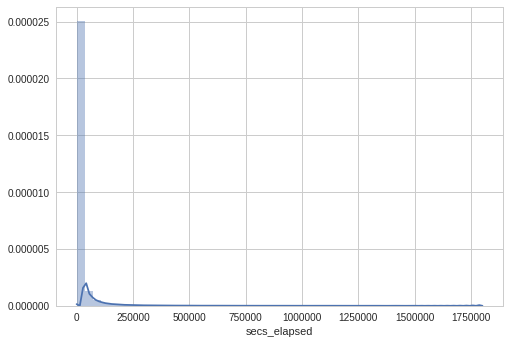

In [65]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

It seems that almost all sessions were less than 5000 seconds long. Let us look deeper into these sessions.

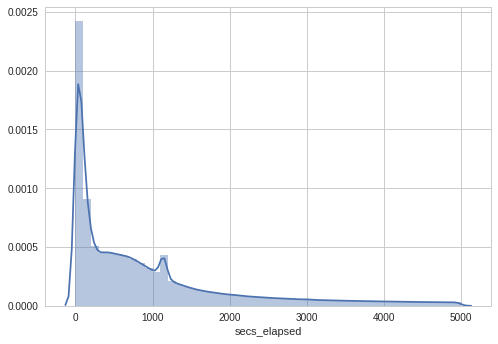

In [66]:
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])

We can see that most the number of sessions greater than 1000 seconds decreases almost exponentially. It is fair to assume that most sessions were less than 1000 seconds long. To cross check this, let us look at its share in the total number of sessions.

In [67]:
len(df_ses[df_ses['secs_elapsed'] < 1000])/len(df_ses[df_ses['secs_elapsed'].notnull()])

0.46654061437103295

**Almost 47% of all sessions were less than 1000 seconds long.** This strongly suggests a decreasing exponential distribution of seconds elapsed on each session. In other words, as the number of seconds increases, the number of instances of sessions requiring that much time exponentially decreases.

Finally, in this section, we will construct a bar plot of all devices used by various users in interacting with the Airbnb Website and App.

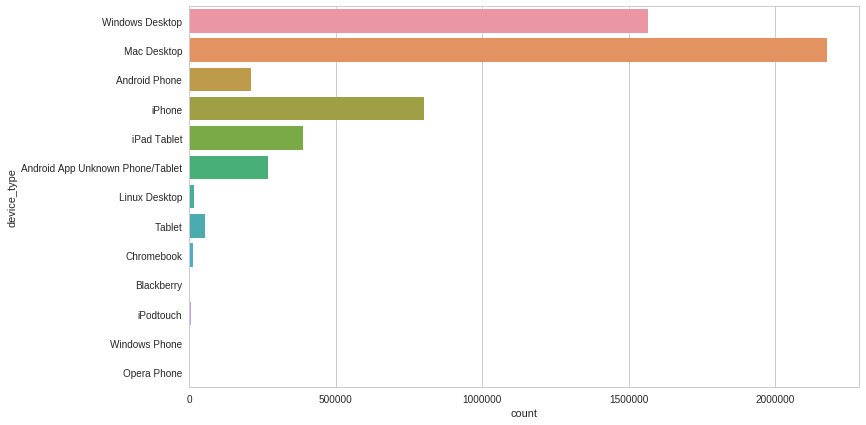

In [68]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_ses)

The **Mac Desktop** is the most popular device among Airbnb Users, followed by the **Windows Desktop.** An interesting insight is that **Apple Products are extremely popular with Airbnb Users.** The iPhone, iPad and the Mac all appear in the list of top 5 most popular devices.

### Training Users Statistics

In this section, we will try to gain insights on our main dataset: the training dataset. These insights will be directly applicable in the later steps of Feature Engineering and Machine Learning. 

The very first step is to plot the frequency of each class.

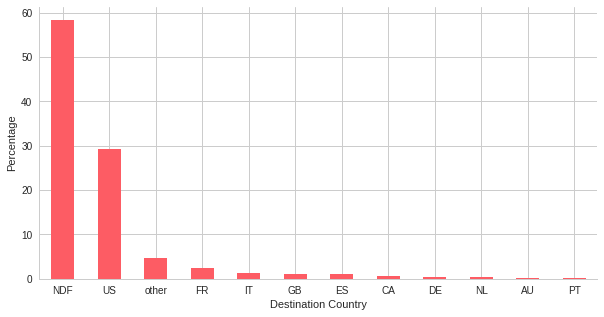

In [69]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

As can be seen above, close to **60% of users have never booked an Airbnb.** Among the users that have, they have overwhelmingly chosen **United States as their first destination.** When training our machine learning model, it is of interest to us to separate the bookers from the non bookers. Subsequent classification amongst bookers would yield a high accuracy as we could use the imbalance of classes to our favor.

Next we are going to create stacked barplots to gain insight into various kinds of users (the people who have booked, the countries they have chosen, etc.)

In [70]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

#### The Stacked Bar Visualisation

The stacked bar plot will the major tool of visualisation in the EDA. The idea was picked up from kevinwu06's excellent notebook on Airbnb Exploratory Analysis. 

The stacked bar chart gives us a collection of proportionately colored bars where each color represents a class (or the destination). Since there are more than 10 classes, I chose to forego the legend. The colors we are concerned with are **dark blue (bottom bar) which corresponds to the NDF class** and **blue (second bottom bar) which corresponds to the US Class**. As we have already seen, these two classes form the majority and therefore, will occupy most of the area of each bar. Each bar has been normalized with respect to its size.

What we will try to deduce is the proportion of the bar which belongs to the non booking class (dark blue). If this is large, it means that particular segment are unlikely to book an Airbnb. If small, it means they are more inclined to do so.

In [71]:
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

#### Gender

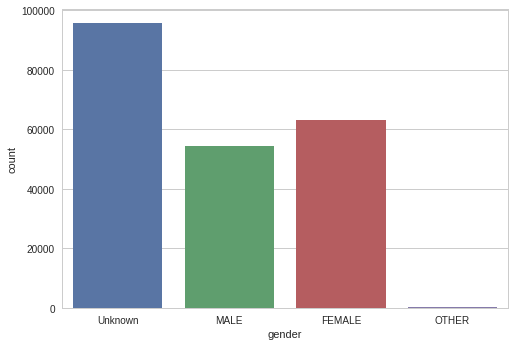

In [72]:
sns.countplot(df_train['gender'].fillna('Unknown'))

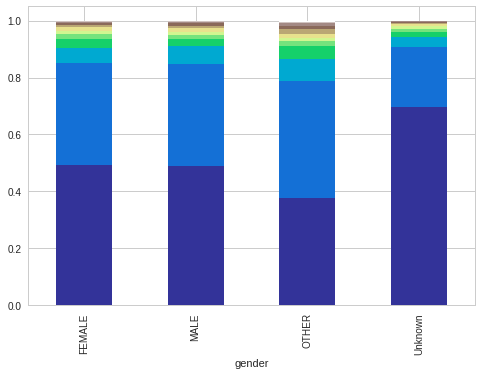

In [73]:
stacked_bar('gender')

We see that the users whose gender is unknown form the majority. Out of the users whose gender is known, **there are more females than males.** This can suggest two things: 
1. There are more female Airbnb Users than male
2. Women are more likely to disclose their gender than men.

One very interesting point of note is that **people who haven't marked their gender are less likely to book an Airbnb.** Also, people who have marked themselves as **'other' are more likely** than any other group to make a booking. This might not be a very potent insight since the other group is a negligible proportion of the population.

#### Age

Let us now study the ages of users and try to gain insights from it. As we saw in a previous section, we do not have the age data of a considerable chunk of the users. Let us try and plot the distribution for the ones we do.

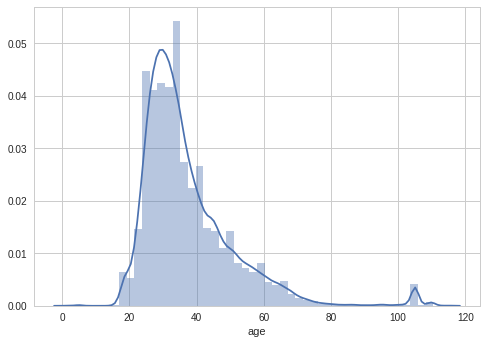

In [74]:
sns.distplot(df_train['age'].dropna())

Are some age groups more likely to book in a particular destination? To answer this question, we will use the box plot and look at the distribution of ages for travellers to a particular country.

(10, 75)

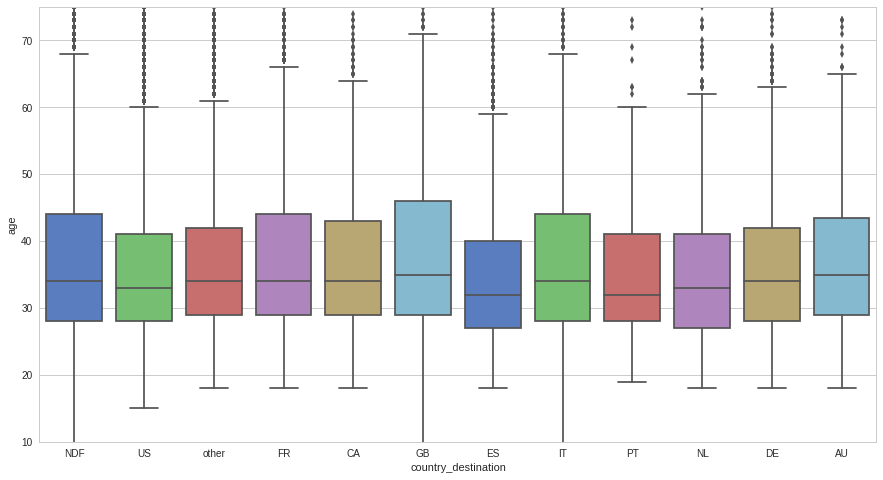

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 75])

From the boxplot constructed, we find that the distribution is more or less the same for every country. **Great Britain** has the highest median age of travellers and **Spain** is more popular amongst younger travellers.

In [76]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [77]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

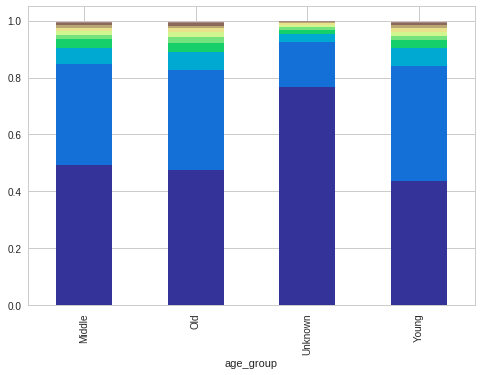

In [78]:
stacked_bar('age_group')

We define a new feature **age_group** to group our users into 4 Age Groups:
* People younger than 40 are labelled as young.
* People aged between 40 and 60 years are labelled as middle aged.
* People aged greater than 60 years are labelled old.
* People with unknown ages are labelled unknown.

We discover that people who have not disclosed their ages **are least likely to book an Airbnb.** Out of the users whose age we know, **Middle Aged People are most likely to book an Airbnb.** Although it must be noted that there isn't a very significant difference amongst the three groups.

#### Signup Method

In a previous section, we already established that **basic** and **Facebook** were the most popular signup methods. **Google** was rarely used. 

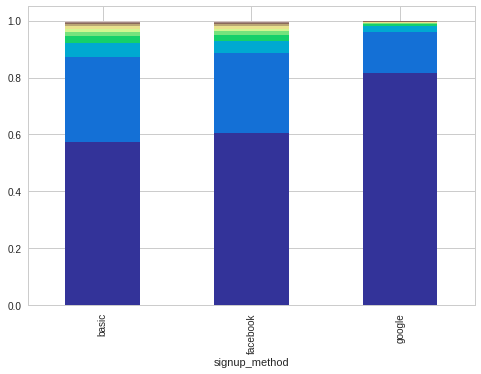

In [79]:
stacked_bar('signup_method')

We discover that people who use **basic** signup method are most likely to book an Airbnb whereas people who use **google** are least likely to make a booking.

#### Language

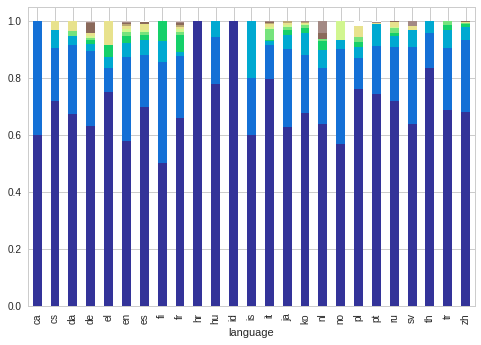

In [80]:
stacked_bar('language')

We see that people who speak **Hungarian** and **Indonesian** made almost no bookings. People who spoke **Finnish** made the most bookings amongst all languages. However since the users are American, we can safely assume that the non English users consitute a minortiy.

#### Affiliate Channels and Providers

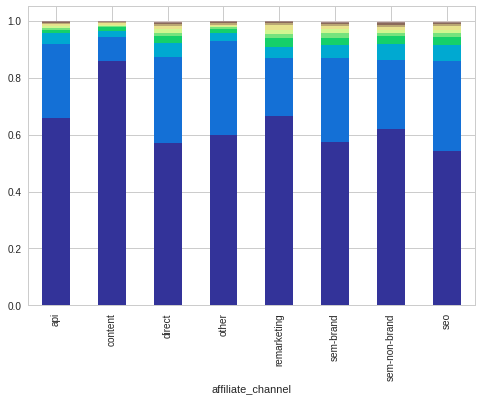

In [81]:
stacked_bar('affiliate_channel')

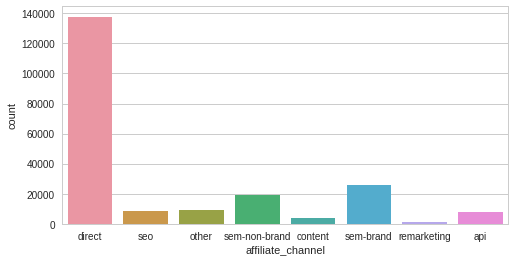

In [82]:
plt.figure(figsize=(8,4))
sns.countplot(df_train['affiliate_channel'])

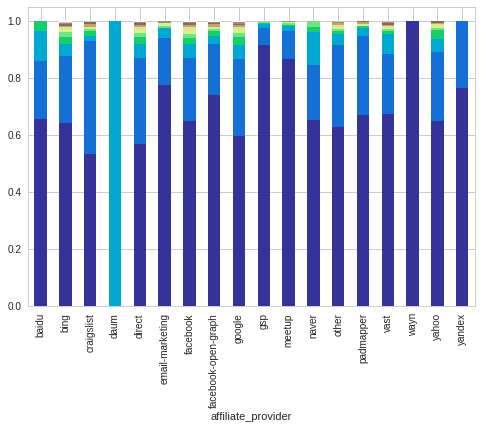

In [83]:
stacked_bar('affiliate_provider')

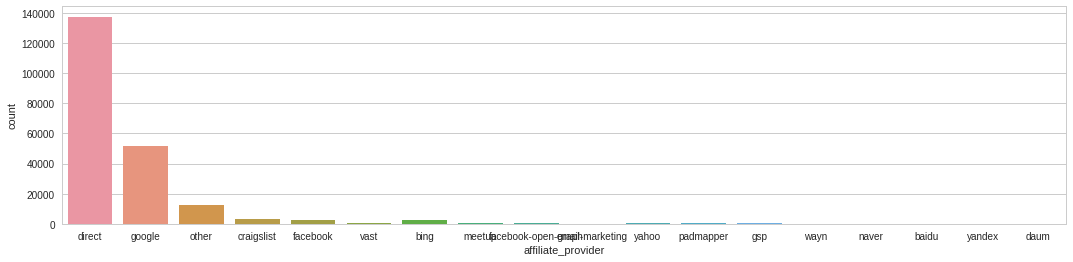

In [84]:
plt.figure(figsize=(18,4))
sns.countplot(df_train['affiliate_provider'])

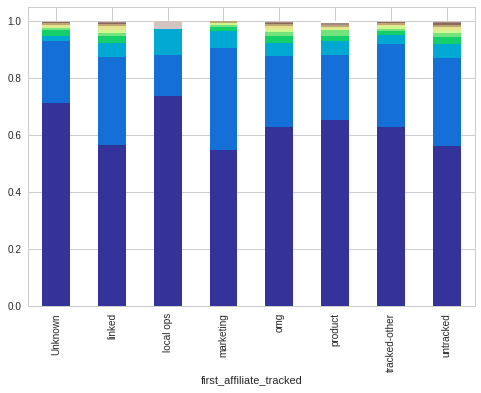

In [85]:
stacked_bar('first_affiliate_tracked')

Some observations from the above visualisations:
* The **Direct Channel** has the most number of conversions to bookings whereas the **Content Channel** has the least.
* **Direct** and **Google** are the most popular affiliate providers.
* **Wayn** has the least percentage of conversions whereas **Daum** has the most. However, we must take this with a pinch of salt as it might be the case that the number of sample points of these categories are extremely few in number (as the count plot suggests).
* Apart from the above, **Google** and **Craigslist** have a good percentage of conversions.
* People with **Marketing** afilliates were most likely to book. People whose first affiliate was tracked as **Local Ops** or was **Unknown** were least likely.

#### Signup Flow

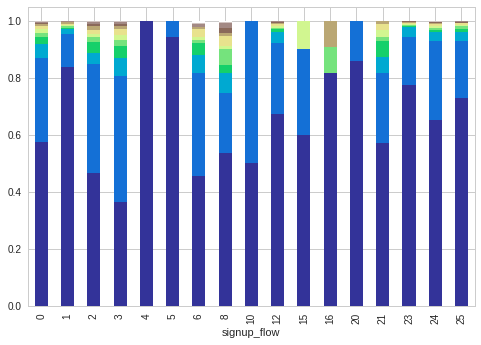

In [86]:
stacked_bar('signup_flow')

The Signup Flow stacked bar chart raises very interesting observations: **people with signup flow 3** are most likely to book an Airbnb. Conversely, people with signup flows **4 and 5 are least likely to convert.**

#### Type of Device, Browser and App Used

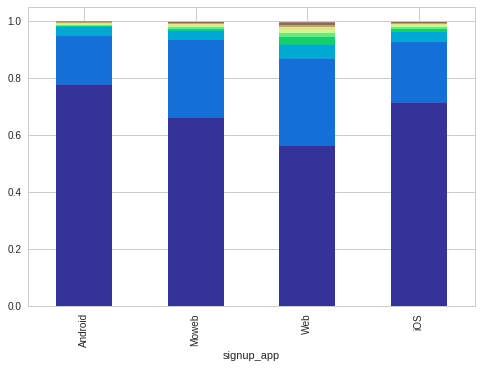

In [87]:
stacked_bar('signup_app')

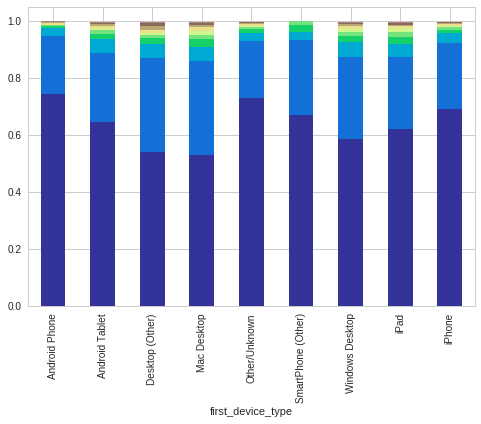

In [88]:
stacked_bar('first_device_type')

As there are too many browsers, we will ignore it for the time being and try to reduce the categories in a later step. For now, we can make the following observations about User Devices:
* Users using the **Web App** are most likely to book an Airbnb whereas **Android Users** are least likely to do so.
* **People with an Android Phone or whose devices were unknown** bought fewer Airbnbs. People on Desktops (Mac or otherwise) bought more.

This strongly suggests that users on their desktop will be more likely to book an Airbnb and Apple Users are more prone to buying on the website whereas Android Users are the least.

#### Dates

Let us first check the trends about when the first accounts were created.

In [89]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])

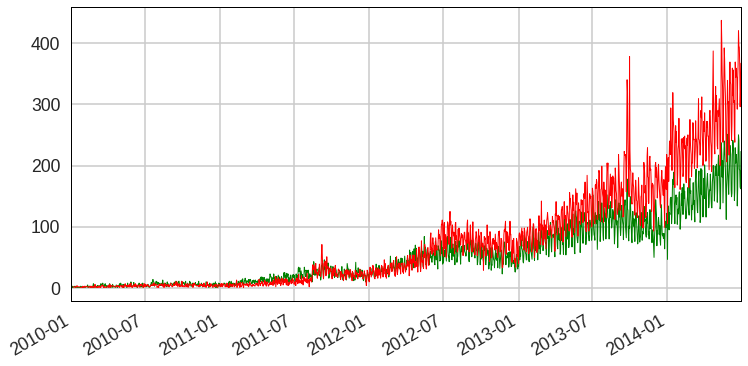

In [90]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

The number of non booking users have increased more than the number of booking users as time passed by. This can be attributed to the fact that more people are using the platform just for exploration. Another reason might be that since the user was on the platform for a longer time, s/he was more likely to go ahead and book a space. This directly  implies that **the earlier the user had created an account on Airbnb, the more likelier s/he was to actually make a booking.**

With all this in mind, we can nos proceed to the Feature Engineering Step. The Features that we have not yet explored in this section will be explored in the next.

## Feature Engineering

![](https://thumbs.gfycat.com/VacantBountifulArgentineruddyduck-max-1mb.gif)

Now, with all these visualisations and insights under our belt, let us proceed to build some new features that would help us get better predictions when we finally train our machine learning model. First, I'd like to extract features from our sessions dataset. Additionally, since we haven't done too much visualisation of our sessions, this would be a good place to do so.

In [91]:
df_ses.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,255.0
1,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,183.0


### Session Features

The first feature I want to engineer is the number of devices a user accesses the app through. **My hunch is that if the user uses a lot of devices, it implies s/he travels very often and hence, would be likely to book an Airbnb.** An additional hypothesis is that if the person travels a lot, s/he must probably be a business traveler and hence would likely be inclined to book Airbnbs within the United States.

The second feature I want is the **total number of seconds the user has spent on Airbnb Sessions.** It will be interesting to see how this correlates with out classes. 

The third feature is **average seconds per session.** Again, I do not have a lot of intuition behind this step but I have a feeling this feature may be useful. 

The fourth feature is **total number of sessions.** As with total seconds, this might indicate greater interest. Additonally, we'll also construct a **number of session types** feature to further quantify the user's interest and engagement.

The final feature I want to look at is **number of short sessions.** These are sessions less than 300 seconds long. We will construct a **number of long sessions** by subtracting it from total number of sessions.

In [92]:
def session_features(df):
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x: total_sessions[x] if x in total_sessions else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x: num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x: num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    return df

In [93]:
def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

In [94]:
def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'

In [95]:
def devices(df):
    df['first_device_type'] = df['first_device_type'].apply(classify_device)
    return df

In [96]:
def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

In [97]:
def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'rest' if x not in ['direct', 'google', 'other'] else x)
    return df

In [98]:
def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df

In [99]:
def languages(df):
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df

In [100]:
def first_booking(df):
    df = df.drop('date_first_booking', axis=1)
    return df

In [101]:
def account_created(df):
    df = df.drop('date_account_created', axis=1)
    return df

In [102]:
def feature_engineering(df):
    df = session_features(df)
    df = df.drop('age', axis=1)
    df = browsers(df)
    df =devices(df)
    df =affiliate_tracked(df)
    df = affiliate_provider(df)
    df = affiliate_channel(df)
    df = languages(df)
    df['is_3'] = df['signup_flow'].apply(lambda x: 1 if x==3 else 0)
    df = first_booking(df)
    df = df.drop('timestamp_first_active', axis=1)
    df = account_created(df)
    df = df.set_index('id')
    df = pd.get_dummies(df, prefix='is')
    return df

In [103]:
total_seconds = df_ses.groupby('user_id')['secs_elapsed'].sum()

In [104]:
average_seconds = df_ses.groupby('user_id')['secs_elapsed'].mean()

In [105]:
total_sessions = df_ses.groupby('user_id')['action'].count()

In [106]:
distinct_sessions = df_ses.groupby('user_id')['action'].nunique()

In [107]:
num_short_sessions = df_ses[df_ses['secs_elapsed'] <= 300].groupby('user_id')['action'].count()
num_long_sessions = df_ses[df_ses['secs_elapsed'] >= 2000].groupby('user_id')['action'].count()

In [108]:
num_devices = df_ses.groupby('user_id')['device_type'].nunique()

In [109]:
df_train = session_features(df_train)

Since we already have our age groups, we can drop the age feature.

In [110]:
df_train = df_train.drop('age', axis=1)

There are more than 50 categories of browsers although the majority use only 5. Therefore, we will club all the minor browsers into the 'Other' category.

Next, from our visualisation above, we saw that desktop users were most likely to book Airbnbs, followed by Tablet users, Phone users and finally people whose devices were unknown. Let us reduce first_device_type into these categories.

In [111]:
df_train = browsers(df_train)

In [112]:
df_train = devices(df_train)

Let us do the same with the affiliates.

In [113]:
df_train = affiliate_tracked(df_train)

In [114]:
df_train = affiliate_provider(df_train)

In [115]:
df_train = affiliate_channel(df_train)

The language used is overwhelmingly English. Therefore, it makes sense to club the others.

In [116]:
df_train = languages(df_train)

In our EDA section, we noticed that people with signup flow 3 had a disproportionate number of conversions. Therefore, we will define an additional feature that identifies these users. We will also revert back our gender fature by filling in the NaNs with Unknown since we deduced that it will lead to an improvement in prediction.

In [117]:
df_train['is_3'] = df_train['signup_flow'].apply(lambda x: 1 if x==3 else 0)
df_train['gender'] = df_train['gender'].fillna('Unknown')

We will drop the first_bookings and the timsestamp features. This is because they do not add any value when finally testing the model with the test set. All our test users have NaNs as first booking and the timestamp is of no significance.

In [118]:
df_train = first_booking(df_train)

In [119]:
df_train = df_train.drop('timestamp_first_active', axis=1)

Finally we will drop the accounts created feature as our training and test sets were separated in the middle of 2014. As a result, all test users registered only in 2014.

In [120]:
df_train = account_created(df_train)

In [121]:
df_train = df_train.set_index('id')

Our dataset is now in a position to have one hot encoding performed on it. Let us now separate our X and y data.

In [122]:
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

In [123]:
X, y = df_train.drop('country_destination', axis=1), df_train['country_destination'].apply(lambda x: class_dict[x])

In [124]:
X = pd.get_dummies(X, prefix='is')

In [125]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2017: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Machine Learning

![](https://cdn-images-1.medium.com/max/2000/1*CFAeP1I6qiU-ZMb-O4xyOA.gif)

The next step is to build a classifier to train our data on and then test its performance against the test data. With all the feature engineering already done in the previous step, applying machine learning should be fairly concise. 

### Model Selection

We need to however come up with a classifier that performs the best, given the features. In such competitions, Ensemble Methods give the best results. We will train our model using three classifiers: **Gradient Boosting**, **Logistic Regression** and **Random Forest** and choose the one with the best accuracy.

In [126]:
#classifiers = [RandomForestClassifier(verbose=1), LogisticRegression(verbose=1), GradientBoostingClassifier(verbose=True)]

#for classifier in classifiers:
#    classifier.fit(train_X, train_y)
#    print("Score: " + str(classifier.score(test_X, test_y)))

The following results were obtained:
* **Logistic Regression** is the least accurate classifier with a logged accuracy of less than 60%.
* On average, the **Gradient Boosting Classifier** performed the best with accuracy close to 65%.

There are, of course, other classifiers that can be tested out in this step but I will stop here and choose **the Gradient Boosting Classifier** as my model of choice.

This classifier has an accuracy of **approximately 65%**. Let us try and improve this by using hyperparameter tuning using Grid Search Cross Validation. Fortunately, like always, scikit-learn has the tools available to us that reduces the amount of code to a bare minimum.

### Hyperparameter Tuning using Grid Search Cross Validation

In [127]:
parameters = {
    'n_estimators': [100,200],
    'max_features': ['auto', 'log2'],
    'max_depth': [3,5]
}

In [128]:
#clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=100)
#clf.fit(train_X, train_y)

In [129]:
#clf.best_params_

The best paramaters obtained by Grid Search can be seen above. We will change the learning rate to 200 for best results.

### Testing and Final Submission

Now, that we have a classifier that has been tuned for best results, we can proceed to make predictions for our test users and build the final submission file.

In [130]:
df_test = pd.read_csv('../input/test_users.csv')
df_test['gender'] = df_test['gender'].replace('-unknown-', 'Unknown')
df_test['age_group'] = df_test['age'].apply(set_age_group)
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_group
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Young
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Unknown
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,Unknown
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,Unknown
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,Unknown


In [131]:
#df_test = feature_engineering(df_test)
#df_test = df_test.drop('is_weibo', axis=1)

In [132]:
#df_test.columns

In [133]:
#X.columns

In [134]:
#pred_prob = clf.predict_proba(df_test)

In [135]:
#pred_prob = pd.DataFrame(pred_prob, index=df_test.index)
#pred_prob.head()

In [136]:
#inv_classes = {v: k for k, v in class_dict.items()}
#inv_classes

In [137]:
def get_top(s):
    indexes = [i for i in range(0,12)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [inv_classes[i[0]] for i in top_five]
    return str(top_five)

In [138]:
#pred_prob['get_top'] = pred_prob.apply(get_top, axis=1)
#pred_prob.head()

In [139]:
#import ast
#pred_prob['get_top'] = pred_prob['get_top'].apply(lambda x: ast.literal_eval(x))

In [140]:
#s = pred_prob.apply(lambda x: pd.Series(x['get_top']),axis=1).stack().reset_index(level=1, drop=True)
#s.name = 'country'

In [141]:
#submission = pred_prob.drop([i for i in range(0,12)] + ['get_top'], axis=1).join(s)
#submission.head()

In [142]:
#submission.to_csv('submission.csv')

## Business Recommendations

Based on the Exploratory Data Analysis and Predictive Modeling performed, we can make the following suggestions to our client (Airbnb):

* The majority of Airbnb's users are on Apple Devices. Additionally, Android users are the minority and don't book that often. **It makes perfect business sense to invest more resources in improving the user experience of iOS apps.** On the other hand, Airbnb could also investigate into the smaller conversion rate of Android Users and try to deduce some correlation with certain quirks of the Android Airbnb App.
* Desktop Users book far more often than other device users. **This could mean that people use smaller devices for surfing and exploration and desktops to make the actual booking.** The User Experience for the apps on different devices  must be tuned accordingly to achieve best results.
* Most of the Airbnb Users tend to book an Airbnb within the country. **Therefore, it makes most sense to give the users more recommendations that are endemic to the country.** American users should get more Experience and Host recommendations within the USA. This is not the case with the current Airbnb site where most recommendations are that of exotic locations in faraway places.
* People who haven't filled out their information such as Age and Gender are the least likely to book Airbnbs. This is likely due to the fact that they are only in the exploration stage. **Maximum marketing effort must be aimed at these people and the most enticing yet affordable offers must be made to them to increase their rate of conversion.**

## Conclusion

![](http://www.clevver.com/wp-content/uploads/2013/10/world-without-books-gifs-imagination.gif)

This notebook demonstrated all the major steps that take place in performig data analysis and predictive modeling in a typical data science problem. The data was wrangled and cleaned. This was followed by some inferential statistics to deduce relationships between features. Extensive EDA was performed to gain insights on the data and these insights were used to extract and engineer new features.

Finally, several classifiers were considered and the **Gradient Boosting Classfier** was selected and its paramters were tuned. This classifer was used to predict the destination of our test users and a submission file was created in the format suggested by Airbnb.

The Official Kaggle Score obtained was **0.86527.** This score can, of course, be improved through more hyperparameter tuning and more advanced feature engineering but the improvement is extremely minimal (considering that the highest score was 0.88). I will therefore conclude this notebook here. Thank you!